# Labor 03: Logisztikus regresszió
### Egyetemi felvételi:

Ebben a feladatban logisztikus regressziót fogunk használni, hogy megjósoljuk egy adott hallgató felvételének tényét az egyetemre.

Tegyük fel, hogy egyetemi adminisztrátorok vagyunk és meg szeretnénk határozni,  egy adott jelentkezőnek az esélyét a sikeres felvételire a két felvételi teszt eredménye alapján. Rendelkezésünkre állnak az eddigi eredmények címkézve, hogy az adott hallgató jelentkezése sikeres volt vagy nem.

Ezt az adathallmazt tudjuk használni a logisztikus regressziónkra.

### 1: Importáljuk be a megfelelő csomagokat:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### 2: Olvassuk be az adatainkat!

In [2]:
data = pd.read_csv('Lab3data.txt', header = None).to_numpy()       # adatok beolvasása majd NumPy tömbbé alakítása
X = data[:,0:2]                                                    # X rendezése
m,n = X.shape                                                      # m adatok száma / n feature-k száma
Y = data[:,2].reshape(m,1)                                         # Y rendezése
del data                                                           # felesleges változó törlése
X_original = X

print('X:', X.shape)                    # adattömbök méretének / adatok számának / feature-k számának kiírása
print('Y:', Y.shape)
print('Adatok száma:',m)
print('Változók (Feature) száma:',n)

X: (100, 2)
Y: (100, 1)
Adatok száma: 100
Változók (Feature) száma: 2


### 3: Jelenítsük meg az adatainkat!

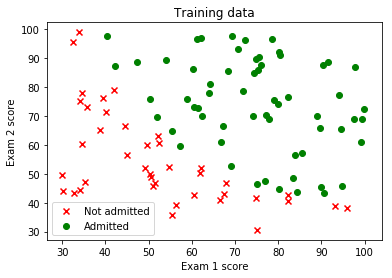

In [3]:
def plotData(X,Y):
    pos=[]                                                  # felvettek (Admit - 1)
    neg=[]                                                  # elutasítottak (Denied - 0)

    for i in range(0,Y.size):                               # Y alapján végignézzük, hogy felvették e az illetőt
        if Y[i] ==0:                                        # ha nem akkor X adott elemei a neg -be mennek
            neg.append(X[i,:])
        elif Y[i] ==1:                                      # ha igen akkor X adott elemei a pos -ba mennek
            pos.append(X[i,:])

    neg = np.array(neg)                                     # neg -> NumPy tömb
    pos = np.array(pos)                                     # pos -> NumPy tömb

    plt.scatter(neg[:,0],neg[:,1],marker='x',c="r", label="Not admitted")   # nem felvettek kirakzolása, x-el, pirosan
    plt.scatter(pos[:,0],pos[:,1],marker='o',c="g", label="Admitted")       # felvettek kirajzolása, körrel, zölddel
    plt.title("Training data")
    plt.xlabel("Exam 1 score")
    plt.ylabel("Exam 2 score")
    plt.legend(loc='lower left')
    plt.show()

    return pos, neg                                          # két lista visszaadása

pos,neg=plotData(X,Y)

Láthatjuk, hogy a két kategória elég jól elkülönül.

### 4: Adatok előkészítése 
##### Adatok normalizálása:
Ha az adataink egy nagyságrendbe esnek a normalizálás nem feltétlen szükséges, de végre hajtható. (Lásd L02)

In [4]:
def featureNormalization(X):
    mean = np.mean(X,axis=0)                               # X oszlopainak átlagai
    std = np.std(X, axis=0,ddof=1)                         # X oszlopainak szórásai (korrigált tapasztalati)                                        

    X_norm = (X - mean) / std                              # a nem volt, akkor csak elvégezzük a normalizálást

    return X_norm,mean,std                                 # visszaadjuk a normalizált X-et, átlagot, szórást

X,mean,std=featureNormalization(X)                         # el is végezzük a normalizálást

#### Bias hozzáadása az X mátrixhoz:
Ahogy már az előzőekben is csináltuk hozzáadunk egy egyesekből álló oszlopot az X mátrixhoz, hogy a tengelymetszet megmaradjon a hipotézisünkben (Lásd. L01 - L02).

In [5]:
X=np.column_stack((np.ones((m,1)),X))       # bias
print(X.shape)                              # visszaellenőrizésnek kiírjuk a mátrix méreteit

(100, 3)


## 5: A model:

Mivel osztályozási, vagyis klasszifikációs problémával állunk szemben az eddigi lineáris regressziós modellünk nem lesz teljesen megfelelő. Nézzünk egy egyszerű példát. Tumor méret alapján próbáljuk eldönteni, hogy a daganat halálos vagy nem.

<img src="files/Pics/L03_Tumor.png" width="400">

Ha az eddig bevezetett módszert alkalmazzuk és a

$ h_w(x)=XW $ 

hipotézist használva illesztünk egy egyenest. Az egyenesünk viszont túllövi a korlátos [0,1] halmazt és nem is elég pontos. Elnanyoltan illesztett egyenesünkre ez után egy határértéket definiálva, legyen ez 0.5, el tudjuk dönteni, hogy mi lesz a predikciónk.

Ha $h_w(x)\geq 0.5$, akkor "y=1", vagyis halálos. <br>
Ha $h_w(x)< 0.5$, akkor "y=0", vagyis nem halálos.  <br>

A predikciónk viszont eshet 0 alá vagy 1 fölé, ami felesleges. Jobb lenne találni egy korlátos hipotézis függvényt,ami teljesíti az alábbi kritáriumot.

$0\leq h_w(x) \leq 1$

Vezessük be a sigmoid függvényt, mely függvény teljesíti ezt a kritériumot, miszerint korlátos [0,1] tartományon.

Szigmoid:

$ g(z) = \frac{1}{1+e^{-z}} $

<img src= "files\Pics\L03_sigmoid.png" width=450>

A szigmoid függvény segítségével gyakorlatilag egy valószínűséget rendelünk minden egyes mintához, hogy mekkora annak az esélye, hogy halálos az a méretű tumor. 

$h_w(x)=P(y=1|X, W)$

A hipotézisünket pedig az almábbi módon bővíthetjük: <br>

$ h_w(x) = g(XW) $ <br>
, ahol $ g(XW) = \frac{1}{1+e^{-XW}} $

$g(XW)\geq0.5$ <br>
akkor, ha $WX\geq0$

Két egyszerű példán vizsgáljuk meg a szigmoid függvénnyel megvalósított osztályozást. <br>

#### Lineáris eset:

$ h_w(x)=g(w_01+w_1x_1+w_2x_2) $

$w=[-3\ 1\ 1]$ 

Predikció: $y=1$ ha $-3+x_1+x_2\geq0$

$x_1+x_2\geq3$ 

<img src= "files\Pics\L03_pelda_1.png" width=200>

#### Nem lineáris eset:

$ h_w(x)=g(w_01+w_1x_1+w_2x_2+w_3x_1^2+w_4x_2^2) $ 

$w=[-1\ 0\ 0\ 1\ 1]$ 

Predikció: $y=1$ ha $-1+x_1^2+x_2^2\geq0$

$x_1^2+x_2^2\geq1$

<img src= "files\Pics\L03_pelda_2.png" width=200>

Hozzuk létre a sigmoid függvényt, majd teszteljük is az eredményt -6, 0, 6 értékekre!

In [6]:
def sigmoid(z):
############################################    
    g = 1/(1 + np.exp(-z))
############################################    
    return g                               # szigmoid függvény értékének visszaadása

print('Függvény érték -6 bemenő értékre: %.3f' % sigmoid(-6))           # teszt -6 -ra
print('Függvény érték  0 bemenő értékre: %.3f' % sigmoid(0))            # teszt 0 -ra
print('Függvény érték  6 bemenő értékre: %.3f' % sigmoid(6))            # teszt 6 -ra 

if sigmoid(-6) < 0.01 and sigmoid(0) == 0.5 and sigmoid(6) > 0.99:
    print("\n A sigmoid() függvény megfelelő. Tovább mehet.")
else:
    print("\n Valami nem stimmel. Korrekció szükséges!")

Függvény érték -6 bemenő értékre: 0.002
Függvény érték  0 bemenő értékre: 0.500
Függvény érték  6 bemenő értékre: 0.998

 A sigmoid() függvény megfelelő. Tovább mehet.


### 6 A költségfüggvény:
Mivel változtattunk a hipotézis függvényünkkön az eddig használt költség függvényünkön is módosítanunk kell. A feladathoz igazítani. Korábbi példáink során bevezetett MSE megfelelően sima konvergenciát biztosított, a módosított hipotézisünkkel a klasszifikációs problémák megoldásához nem a legjobb választás, mivel sok lokális mininmum ponttal rendelkező nem konvex függvényt fog eredményezni. A kérdés az, tudunk-e találni egy olyan költség függvényt, amely osztályozási feladatok során konvex költség függvényt tud definiálni? Konvex függvényen a gradiens módszerünk sokkal kisebb valószínűséggel fog beragadni lokális minimum pontba.

<img src="files\Pics\L03_Costfunction.png" width=600>


Legyen:

$ C(w) = {-log(h_w(x)),\   ha\ y=1} $ 

$ C(w) = {-log(1-h_w(x)),\ ha\ y=0} $

<img src="files\Pics\L03_LogCost.png" width=300>

Tehát a költségfüggvényként használjuk az alábbi összefüggést:

$ C(w) = -\frac{1}{m} \sum{y^i\cdot\log(h_w(x^i))-(1-y^i)\cdot\log(1-h_w(x^i))} $


### 7: A gradiens csökkentés (Gradient Descent Algorithm)
Célunk továbbra is a költség függvény minimalizálása. A Gradiens csökkentés továbbra is működő képes, miszerint a súlyokat a költség függvény deriváltjának segítségével csükkentjük.

$w_j:=w_j-\mu\frac{\partial}{\partial w_j}C(w)$ 

A költségfüggvény parciális deriváltja pedig az eddig megszokott módon számolható:

$ \frac{\partial}{\partial w_j}C(w)=\frac{1}{m}\sum_{i=1}^{m}(h_w(x^i)-y^i)\cdot x_j^i $



### costFunction definiálása:

Írjuk meg a costFunction definícióját, majd teszteljük le két w értékkel!

In [7]:
def costFunction(w,X,Y):
######################################################################
    h = np.array(sigmoid(X@w))                                              # predikció kiszámítása (részszámítás) 
    C = (1/m) * np.sum(((-Y) * np.log(h)) - ((1-Y)*(np.log(1-h))))          # költségfüggvény kiszámítása

    grad = (X.transpose())@(h-Y)/m                                          # gradiens kiszámítása
######################################################################
    return C, grad                                                          # eredmények visszaadása

In [8]:


initial_w = np.zeros(((n+1),1))                                             # kezdeti súlyok (null vektor) létrehozása
C1,grad1 = costFunction(initial_w,X,Y)                                 # költségfüggvény tesztelése 1

print('''Cost and Gradient  at initial weights (zeros):
Expected cost (approx.): 0.693
Computed:''',C1)
print('''Expected gradient(approx.):
 [[-0.1]
 [-0.28]
 [-0.25]]
Computed:\n''',grad1)

test_w = np.array([[-24], [13], [16]])                                    # teszt súlyok létrehozása [-24;0.2;0.2]
C2, grad2 = costFunction(test_w,X,Y)                                 # költségfüggvény tesztelése 2
print('\nTest weights:',test_w.transpose())
print('''Cost and Gradient  at test weights:
Expected cost (approx.): 0.218
Computed:''',C2)
print('''Expected gradient(approx.):
 [[-0.44]
 [-0.14]
 [-0.06]]
Computed:\n''',grad2)
print('\n')

Cost and Gradient  at initial weights (zeros):
Expected cost (approx.): 0.693
Computed: 0.6931471805599453
Expected gradient(approx.):
 [[-0.1]
 [-0.28]
 [-0.25]]
Computed:
 [[-0.1       ]
 [-0.27981946]
 [-0.24972806]]

Test weights: [[-24  13  16]]
Cost and Gradient  at test weights:
Expected cost (approx.): 0.218
Computed: 7.747803887700617
Expected gradient(approx.):
 [[-0.44]
 [-0.14]
 [-0.06]]
Computed:
 [[-0.44154019]
 [-0.14340547]
 [-0.06486541]]




### 8: Gradiens csökkentéses módszer definiálása:
Páldánk során meghatározott iterációig végezzük az algoritmust a jobb szemléltetés végett.

In [9]:
def gradientDescent(X,Y,w,learning_rate,num_iters):
    C_history = []                                      # C_history változó létrehozása
##################################################
    for i in range(num_iters):                          # epoch számig folytatjuk a grádiens módszert
        C, grad = costFunction(w,X,Y)                   # költségfüggvény értékének / grádiens meghatározása
        w = w - (learning_rate*grad)                    # új súlyok beállítása
        C_history.append(C)                             # költségfüggvény történet bővítése
##################################################
    return w, np.array(C_history)                       # visszaadjuk a számolt súlyokat és a kötlségfüggvény történetet

### 9: Grádiens módszer kirpóbálása több tanulási rátára:

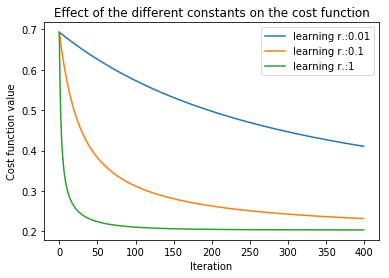

In [10]:
w = np.array([[0],[0],[0]])     # kezdeti súlyok
epoch = 400

w_a, C_history_a = gradientDescent(X,Y,w,0.01,epoch)                             
plt.plot(range(C_history_a.size), C_history_a, label= "learning r.:0.01")
                                                       
w_b, C_history_b = gradientDescent(X,Y,w,0.1, epoch)                             
plt.plot(range(C_history_b.size), C_history_b, label= "learning r.:0.1")

w, C_history = gradientDescent(X,Y,w,1,epoch)
plt.plot(range(C_history.size), C_history, label= "learning r.:1")              

plt.title("Effect of the different constants on the cost function")
plt.xlabel("Iteration")
plt.ylabel("Cost function value")
plt.legend()
plt.show()

A fenti ábrán láthatjuk, hogy a tanulási ráta miként befolyásolta az eredményünket:<br>
A tanulási rátát $(\mu)$ kicsi értéknek választva a konvergencia lassú. <br>
A tanulási rátát $(\mu)$ növelve a konvergencia gyorsul.<br>

In [11]:
print('''The cost function at found weights by the gradient descent alg.:
Expected (approx): 0.203
Computed: %.04f''' % C_history[-1])
print('''Weights expected (approx.):
[1.658 3.883 3.619]
Weights computed: \n''', w.transpose())

The cost function at found weights by the gradient descent alg.:
Expected (approx): 0.203
Computed: 0.2036
Weights expected (approx.):
[1.658 3.883 3.619]
Weights computed: 
 [[1.6582185  3.88371249 3.61890756]]


### 9: Kirajzoljuk a döntési határt

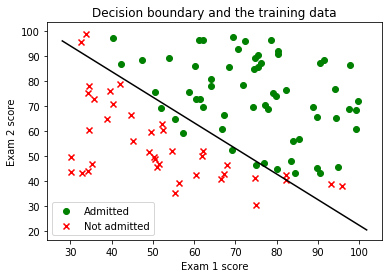

In [12]:
plt.scatter(pos[:,0],pos[:,1],c="g", marker="o",label="Admitted")     # pos kirajzolása, körökkel, zölddel
plt.scatter(neg[:,0],neg[:,1],c="r",marker="x",label="Not admitted")  # neg kirajzolása, x-ekkel, pirossal

Exam1_val     = np.array([min(X_original[:, 0])-2, max(X_original[:, 0]+2)]) # döntési határhoz felvesszünk két x értéket
Exam1_norm = (Exam1_val - mean[0]) / std[0]
Exam2_norm = (-w[0]-w[1]*Exam1_norm)/w[2]                           # kiszámoljuk a hozzájuk tartozó y -t
Exam2_val     = (Exam2_norm * std[1]) + mean[1]

plt.plot(Exam1_val,Exam2_val,"k")                                   # feketével felrajzoljuk a döntési határt
plt.title("Decision boundary and the training data")        
plt.xlabel("Exam 1 score")
plt.ylabel("Exam 2 score")
plt.legend(loc=0)
plt.show()

### 10: Predikció
A predikció kiszámítása során ügyelnünk kell arra, hogy a mintán ugyan azokat a műveleteket elvégezzük, amiket a tanítás előtt az adat előkészítő fázisban is. Tehát ha normalizáltuk az adatainkat az új adatot is normalizálni kell, illetve a BIAS-t hozzáfűzni. Ezek után az elmentett súlyvektrounkkal kiszámolhatjuk a predikciónkat.

In [15]:
def predict(X):              # predikciós függvény
###########################################    
    X = (X-mean)/std                             # a beadott eredmények normalizálása
    X = np.append(np.ones((1)),X)                # bias
    h = sigmoid(X@w)                             # h= sigmoid(Xw)
    if h >= 0.5:
        p = 1
    else:
        p = 0         
###########################################    
    return p, h                                    

NewScore = np.array([45,85])
pred, h =predict(NewScore)            # eredmény 45 és 85 pontra
print('''Expected result of the prediction with [45 , 85] (approx.):
Accepted (1) with 0.767 possibility
Predicted: %.0f with %.4f possibility''' % (pred, h[0]))

Expected result of the prediction with [45 , 85] (approx.):
Accepted (1) with 0.767 possibility
Predicted: 1 with 0.7676 possibility


### 11: Pontosság
Vizsgáljuk meg hogy teljesít a lináris modellunk az eredeti adatok kiértékelése során. Számoljuk ki az algoritmus pontosságát. Ehhez használhatjuk a korábban megírt predict() függvényt vagy az összes mintát egy Batchben is kiértékelhetjük. 

In [16]:
def calculateAccuracy():                                    # pontosság függvény
    predictions= (sigmoid(X@w)>0.5)                         # minden eredeti X-re kiszámoljuk a predikciót
    percentage=(sum(predictions==Y)/m)*100                  # ha nagyobb, mint 0.5 akkor pos ellenkező esetben neg
    return percentage                                       # összehasonlítjuk az Y elemeivel az eredményt és százalékot
                                                            # számolunk, ami tükrözi a pontosságot

print(float(calculateAccuracy()), '% accuracy (approx. 89.0 % expected)')

89.0 % accuracy (approx. 89.0 % expected)


## Fejlettebb csomagokkal

In [17]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression                       

data = pd.read_csv('Lab3data.txt', header = None)       # adatok beolvasása
XX = data.iloc[:, 0:2].values.reshape(-1, 2)            # adatok szétválogatása
YY = data.iloc[:, 2].values.reshape(-1,)                # adatok szétválogatása (LogReg fit-je egy 1d tömböt vár!)

logReg = LogisticRegression().fit(XX,YY)
test = np.array([[45, 85]])                             # mivel egy mintánk van ezért (1,2) array kell ezért a dupla []
pred = logReg.predict(test)                             # sima predikció
pred_p = logReg.predict_proba(test)                     # a teszteset valszínűségi predikciója

print("""Prediction for the approval:""",int(pred),"""
The value of the probability:""",pred_p[0,1])

acc = logReg.score(XX,YY)                               # pontosság kiszámolása 
print('Accuracy on the training data:',acc)

Prediction for the approval: 1 
The value of the probability: 0.6146296634498865
Accuracy on the training data: 0.87


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
